# PyMCによる線形回帰モデルの推定
### Pythonコンピュータシミュレーション入門 ―人文・自然・社会科学の数理モデル―(P194 7.3.5 単回帰モデルを参照)

$$
y_i = \alpha + \beta x_i \\
y \sim N(\mu = \alpha + \beta x, \sigma = \varepsilon ) \\
\alpha \sim N (\mu_{\alpha}, \sigma_{\alpha} ) \\
\beta \sim N(\mu_{\beta}, \sigma_{\beta}) \\
\varepsilon \sim U(0, h_s)
$$

1. 線形回帰モデル: $y_i = \alpha + \beta x_i$
   - $y_i$は$i$番目の目的変数
   - $x_i$は$i$番目の説明変数
   - $\alpha$は切片
   - $\beta$は傾き

2. 目的変数$y$の分布: $y \sim N(\mu = \alpha + \beta x, \sigma = \varepsilon )$
   - 平均$\mu = \alpha + \beta x$
   - 標準偏差$\sigma = \varepsilon$
   - $\varepsilon$は観測誤差の標準偏差

3. 切片$\alpha$の事前分布: $\alpha \sim N (\mu_{\alpha}, \sigma_{\alpha} )$
   - 平均$\mu_{\alpha}$
   - 標準偏差$\sigma_{\alpha}$

4. 傾き$\beta$の事前分布: $\beta \sim N(\mu_{\beta}, \sigma_{\beta})$
   - 平均$\mu_{\beta}$
   - 標準偏差$\sigma_{\beta}$

5. 観測誤差の標準偏差$\varepsilon$の事前分布: $\varepsilon \sim U(0, h_s)$
   - 0から$h_s$までの一様分布

In [1]:
# -*- coding: utf-8 -*-
import pymc as pm
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

%matplotlib inline

#### 単回帰モデルを用いたデータ生成

In [2]:
np.random.seed(123)
num = 100
alpha_real = 2.5
beta_real  = 0.9
x = np.random.normal(10, 1, num)
y_real = alpha_real + beta_real*x
eps_real = np.random.normal(0, 0.5, size=num)
y = y_real + eps_real

In [3]:
print(x.mean(), x.std(), x.min(), x.max(), x.shape)
print(y.mean(), y.std(), y.min(), y.max(), y.shape)

10.027109073490358 1.1282404704779612 7.201410894539276 12.392365265937727 (100,)
11.514630385186251 1.1168314648486553 8.431248248774999 13.881264186945069 (100,)


Text(0, 0.5, 'density')

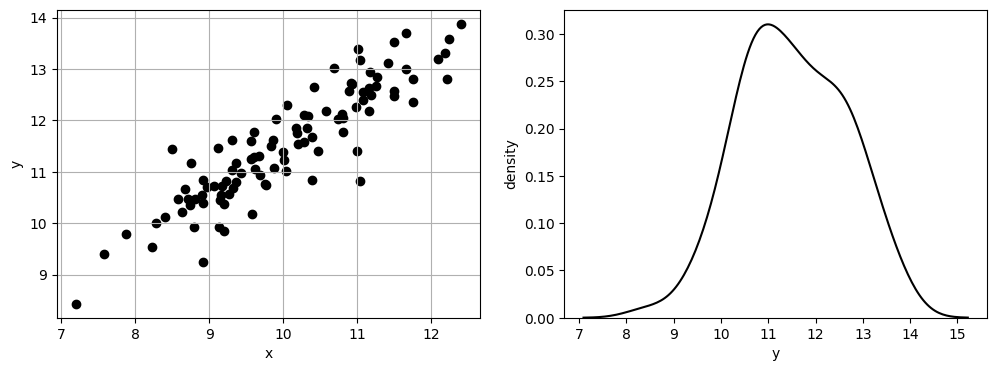

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
#axs[0].plot(x, y_real, c='k')
axs[0].scatter(x, y, c='k')
axs[0].grid()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

sns.kdeplot(data=y, ax=axs[1], color='k')
axs[1].set_xlabel('y')
axs[1].set_ylabel('density')

#plt.savefig('fig_Bayes_PyMC3_Regre_01.png')

#### Bounded Variables
https://docs.pymc.io/api/bounds.html <br>
HalfCauchy: https://docs.pymc.io/api/distributions/continuous.html

#### deterministic変数
Deterministic transforms: https://docs.pymc.io/notebooks/api_quickstart.html<br>
Model: https://docs.pymc.io/api/model.html

#### Half Cauchy分布
PyMC3 API: https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfCauchy<br>
Wikipedia: https://ja.wikipedia.org/wiki/コーシー分布<br>
Wolfram Mathworld – Cauchy distribution: https://mathworld.wolfram.com/CauchyDistribution.html


### パラメータのmuを確率にする

In [5]:
# 線形回帰モデル
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta  = pm.Normal('beta',  mu=1.0, sigma=1.0)
    epsilon = pm.HalfCauchy('epsilon', 5)
#    mu = pm.Deterministic('mu', alpha+beta*x)
    y_rv = pm.Normal('y_rv', mu=alpha+beta*x, sigma=epsilon, observed=y)

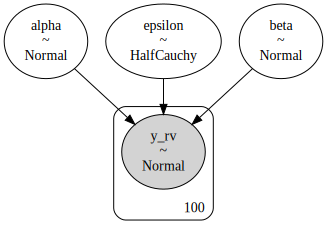

In [6]:
tree_model = pm.model_to_graphviz(model_linear)
tree_model
#木構造の図をPNGで保存したい場合には，次の行のコメントをはずす
#tree_model.render(filename='fig_Bayes_PyMC3_Regre_TreeModel', format='png') # DOT言語ファイルと画像ファイルの保存

In [7]:
burnin = 1000
with model_linear:
    start = pm.find_MAP() #与えられたモデルに対して最大事後確率（Maximum A Posteriori、略してMAP）推定値を求める (良い初期値から開始するため)
    step  = pm.NUTS() #No-U-Turn Sampler（NUTS） (NUTS)を指定
    trace = pm.sample(draws=5000+burnin, tune=1000, start=start, step=step, cores=2, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

<ipython-input-7-986926b27c0c>:5: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=5000+burnin, tune=1000, start=start, step=step, cores=2, return_inferencedata=False)


In [8]:
#1. az.summary(): 事後分布の要約 (事後分布の平均、標準偏差、MC誤差、信用区間（HDI: Highest Density Interval）などの要約統計量を表形式で表示します。これにより、パラメーター推定値の概要と不確実性を迅速に把握できます。)
az.summary(idata)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.564,0.448,1.708,3.411,0.008,0.005,3478.0,4246.0,1.0
beta,0.893,0.044,0.807,0.976,0.001,0.001,3430.0,4194.0,1.0
epsilon,0.496,0.037,0.430,0.567,0.001,0.000,4966.0,4695.0,1.0


In [9]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.564,0.448,1.708,3.411,0.008,0.005,3478.0,4246.0,1.0
beta,0.893,0.044,0.807,0.976,0.001,0.001,3430.0,4194.0,1.0
epsilon,0.496,0.037,0.430,0.567,0.001,0.000,4966.0,4695.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>]], dtype=object)

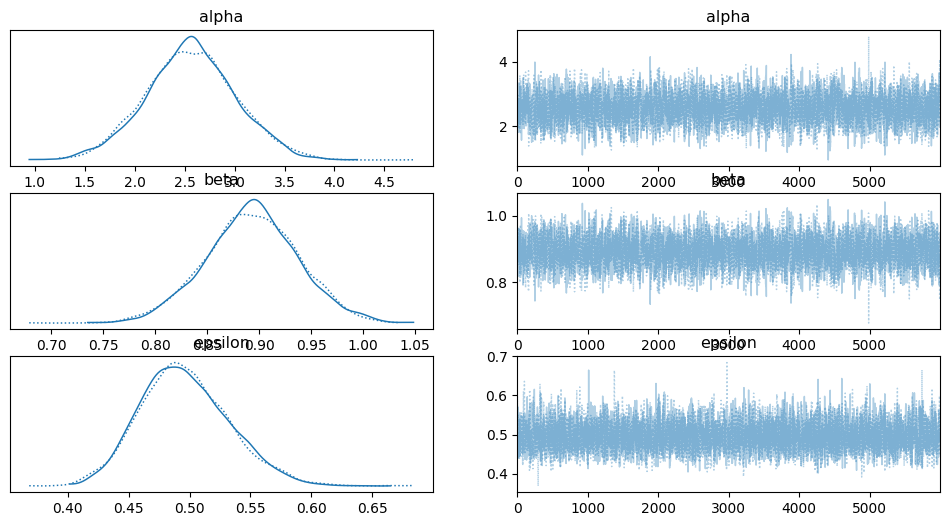

In [10]:
#2. 2. az.plot_trace(): トレースプロット (各パラメーターのサンプリングトレース（サンプルの系列）と事後分布のヒストグラムを表示します。このプロットは、サンプリングの収束状況や事後分布の形状を視覚的に評価するのに役立ちます。)
az.plot_trace(idata)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

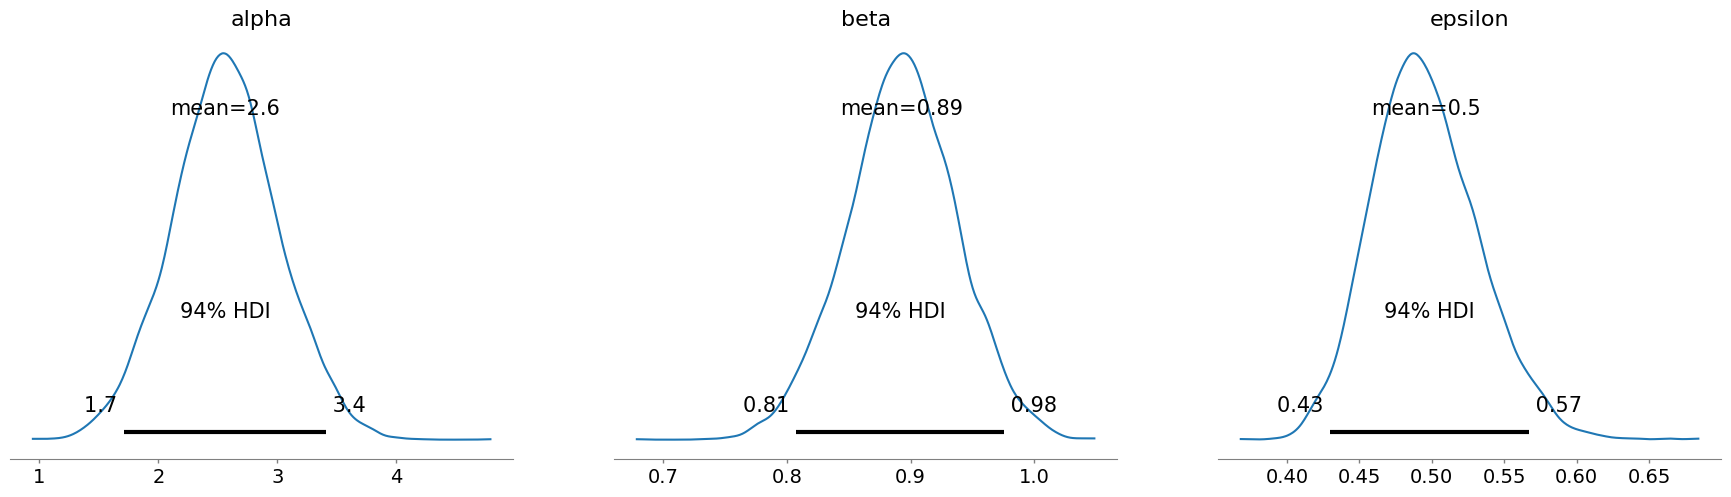

In [11]:
#3 3. az.plot_posterior(): 事後分布のプロット (パラメーターの事後分布をプロットし、平均や中央値、信用区間（HDI）を表示します。また、特定の閾値に基づいた事後確率の注釈を追加することもできます。)
az.plot_posterior(idata)

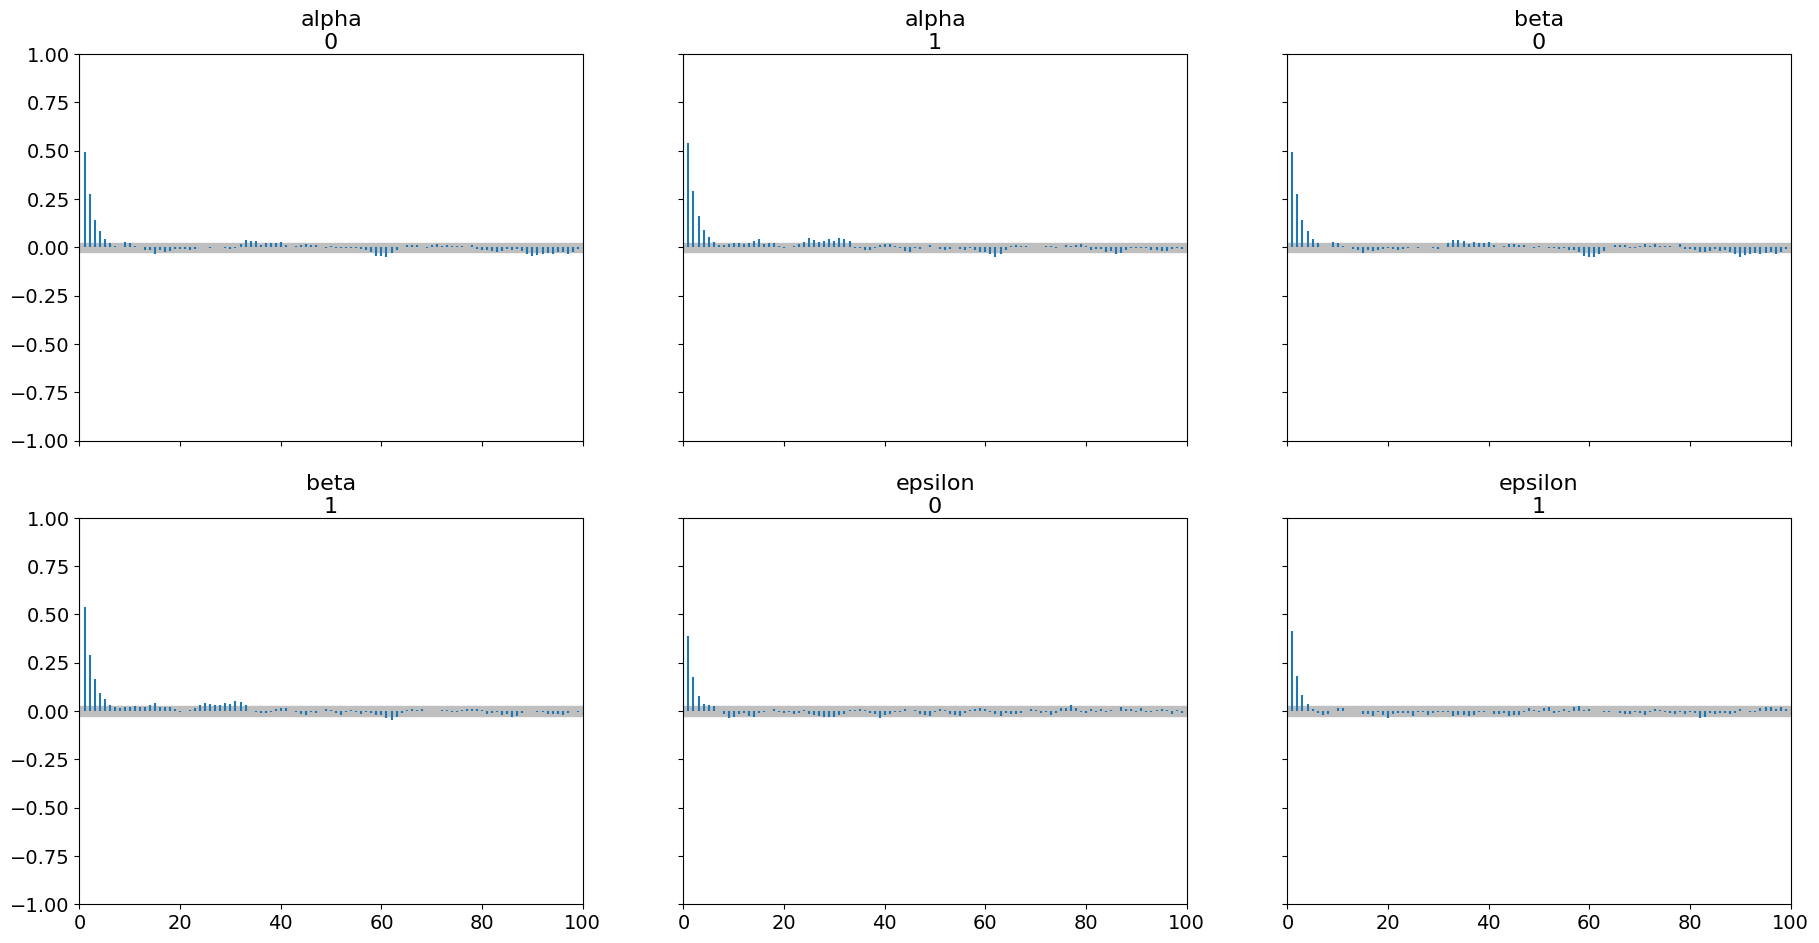

In [12]:
#4. az.plot_autocorr(): 自己相関のプロット (サンプリングされた系列の自己相関を表示します。自己相関が高い場合、サンプル間に相関があり、サンプリング効率が低いことを示します。これは、サンプルの薄間引き（thinning）を検討するか、サンプラーのパラメーターを調整する必要があることを示唆しています。)
az.plot_autocorr(idata)
plt.savefig('fig_Bayes_PyMC3_Regre_autocorr.png')

array([[<Axes: ylabel='beta'>, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='epsilon'>, <Axes: xlabel='beta'>]],
      dtype=object)

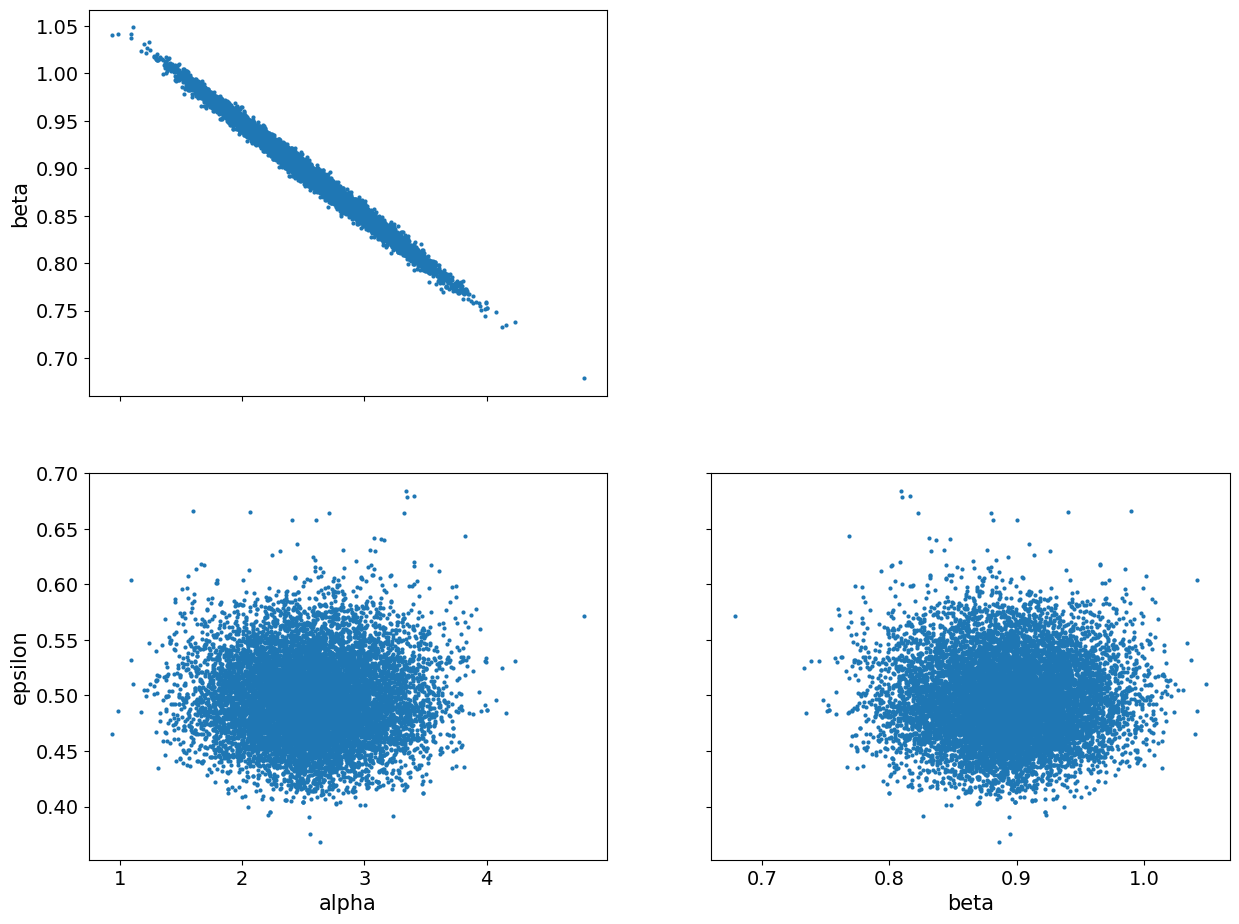

In [13]:
#5. az.plot_pair(): ペアプロット (複数のパラメーター間の関係性を散布図として可視化し、各パラメーターの事後分布も同時に表示します。パラメーター間の相関や事後分布の形状を把握するのに適しています。)
az.plot_pair(idata)

#### $\alpha$と$\beta$の相関を見るために位相平面を描く。ここに，等高線で表す

### 事後分布の考察と視覚化

In [14]:
alpha_mean = trace['alpha'].mean()
beta_mean  = trace['beta'].mean()
print(alpha_mean, beta_mean)
y_rv_mean = alpha_mean + beta_mean*x

2.56440878976936 0.8925861376792679


Text(0, 0.5, 'y')

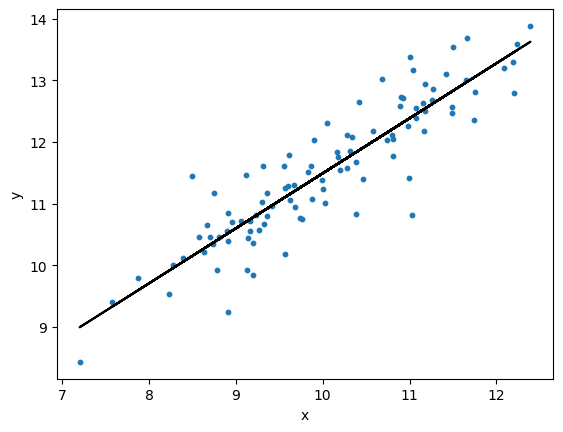

In [15]:
plt.plot(x,y_rv_mean, c='k')
#plt.plot(x,y_real, c='r')
plt.scatter(x,y, s=10)

plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('fig_Bayes_PyMC3_Regre_mean.png')

#### 回帰直線の不確実性を表す

Text(0, 0.5, 'y')

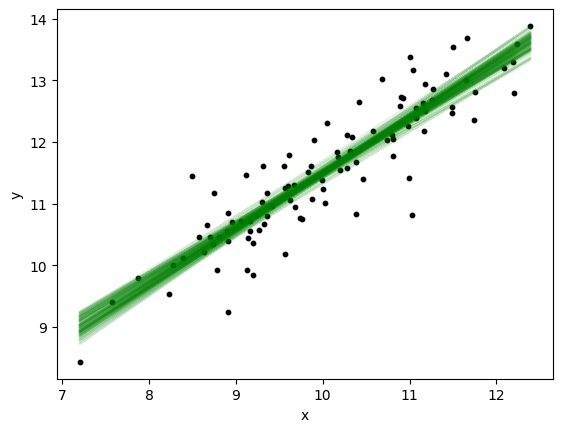

In [16]:
for i in range(100):
    y_rv_pred = trace['alpha'][i] + trace['beta'][i]*x
    plt.plot(x, y_rv_pred, c='g', alpha=0.1)
plt.scatter(x,y, s=10, c='k')

plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('fig_Bayes_PyMC3_Regre_uncertainty.png')

In [17]:
with model_linear:
    # 事後予測サンプルを生成
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=False)
    idata_ppc = pm.to_inference_data(posterior_predictive=ppc)

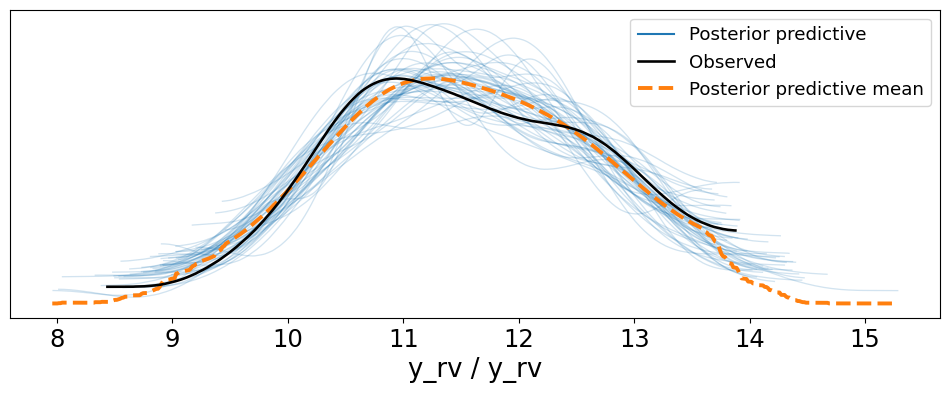

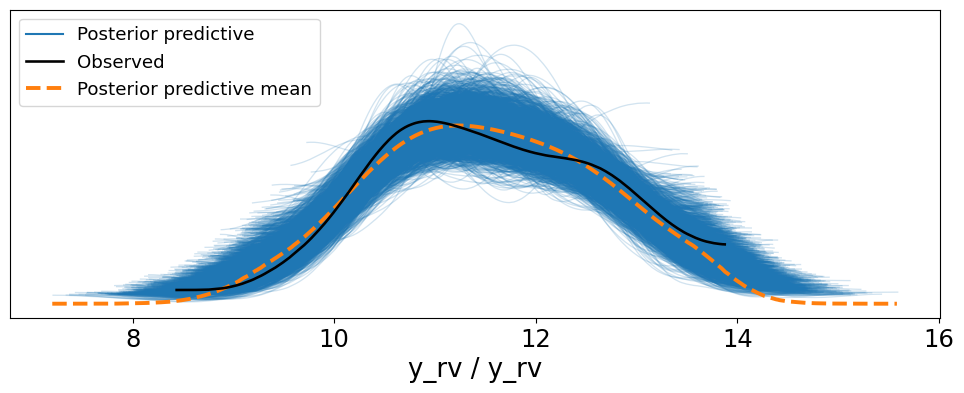

In [18]:
# 分布によるチェック
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));

In [19]:
shape = ppc['y_rv'].shape
print(f"チェーン数: {shape[0]}, サンプリング数: {shape[1]}, 観測値数: {shape[2]}")

チェーン数: 2, サンプリング数: 6000, 観測値数: 100


In [20]:
# 事後予測分布から算出された辞書データ
posterior_predictive_sample = ppc

# 事後予測サンプリングの結果をフラット化
flattened_data = posterior_predictive_sample['y_rv'].reshape(-1, posterior_predictive_sample['y_rv'].shape[-1])

# データフレームを作成
# ここでは、各列が1つの観測値を表し、行がサンプリング番号（連結されたチェーンとサンプルインデックス）を表します
df = pd.DataFrame(flattened_data, columns=[f"Obs_{i+1}" for i in range(flattened_data.shape[1])])

# チェーンインデックスとサンプリングインデックスを行に追加
chain_lengths = posterior_predictive_sample['y_rv'].shape[1]
df['Chain_Index'] = np.repeat(np.arange(posterior_predictive_sample['y_rv'].shape[0]), chain_lengths)
df['Sample_Index'] = np.tile(np.arange(chain_lengths), posterior_predictive_sample['y_rv'].shape[0])

df

,Obs_1,Obs_2,Obs_3,Obs_4,Obs_5,Obs_6,Obs_7,Obs_8,Obs_9,Obs_10,...,Obs_93,Obs_94,Obs_95,Obs_96,Obs_97,Obs_98,Obs_99,Obs_100,Chain_Index,Sample_Index
0,10.696045,12.707003,12.366979,9.862000,10.960562,11.241899,8.512793,11.043310,13.338042,11.003242,...,11.824825,12.185660,10.653607,13.065863,9.887017,10.632483,11.432443,10.990664,0,0
1,9.285211,12.415188,11.090716,10.376450,10.261010,12.758777,9.370540,11.015944,11.475970,11.648157,...,11.918186,11.531115,12.274233,12.658650,10.547408,9.482593,12.756450,11.163359,0,1
2,10.675609,12.162977,11.213181,10.508132,11.353878,12.955537,8.447488,11.531888,12.556093,10.209863,...,12.261111,12.361920,11.148706,12.522154,10.239016,10.141623,11.790184,10.547472,0,2
3,10.210740,12.414666,12.328716,10.282412,10.910538,13.733729,9.477222,10.994776,12.746980,10.786641,...,11.883892,13.380168,10.052499,12.704809,10.400594,10.057379,12.109446,11.665581,0,3
4,10.259252,12.064461,11.546577,11.087184,10.758132,13.425653,8.874954,10.823572,12.563050,9.762179,...,12.300343,11.882693,11.533948,12.249099,10.083800,9.443951,11.620716,11.985940,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11.405874,12.639033,10.416376,11.093633,11.907308,13.044979,8.961180,11.065379,12.971886,11.328076,...,10.792653,13.434917,11.423416,12.044000,10.103962,10.814282,11.921189,10.371857,1,5995
11996,10.415247,12.490705,12.954815,10.116477,11.111132,12.925644,9.351271,11.394267,12.944668,10.174730,...,12.117004,12.830741,11.230096,13.479074,10.202388,9.862706,11.530139,12.232520,1,5996
11997,10.634685,12.417864,11.235185,10.021156,11.383807,12.240096,8.436739,10.539065,11.942861,10.934628,...,11.761078,12.243968,11.428775,12.410241,10.566313,9.750255,12.489342,10.770658,1,5997
11998,10.435230,13.268636,12.388856,10.358945,11.169604,12.668457,8.742184,11.124452,13.269459,9.869788,...,11.856865,12.950963,11.588157,11.760513,10.764032,10.007732,10.848289,11.059237,1,5998


In [21]:
print(x.min(), x.max())

7.201410894539276 12.392365265937727
